<a href="https://colab.research.google.com/github/mikemaurrasse-hash/mikemAIM460/blob/main/Grp_Project_1_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Project 1
Upload `diabetes.csv` when prompted, then run all cells.
It performs EDA, confusion matrix, custom metrics, ROC/AUC (manual + sklearn), feature engineering tests, multiple models (Logit, SVM, KNN, Tree, RF), SMOTE, and ensemble.

In [1]:
# === 1. Data Upload & Initial Load ===
# Upload the dataset (diabetes.csv) into Colab.
# This allows us to read the file into a Pandas DataFrame for analysis.
# The first few rows are displayed to confirm the data loaded correctly.

from google.colab import files
import pandas as pd

uploaded = files.upload()
df = pd.read_csv("diabetes.csv")
print("Data loaded:", df.shape)
df.head()

Saving diabetes.csv to diabetes.csv
Data loaded: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
# === 2. Imports & Setup ===
# Import required Python libraries for:
# - data handling (pandas, numpy)
# - visualization (matplotlib, seaborn)
# - machine learning models (scikit-learn)
# - preprocessing and metrics (imputation, scaling, ROC, confusion matrix)
# We also suppress warnings for cleaner output.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

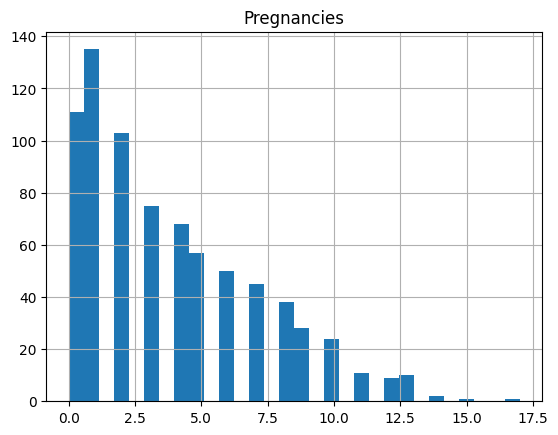

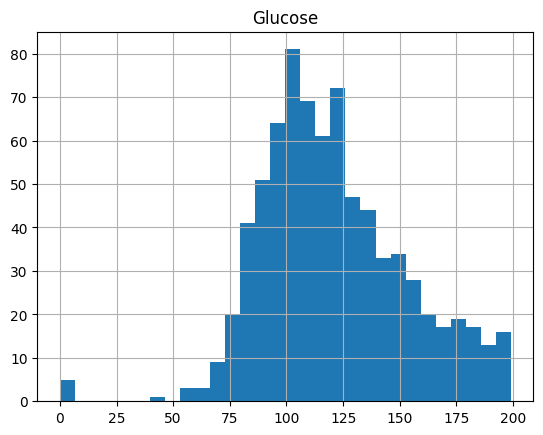

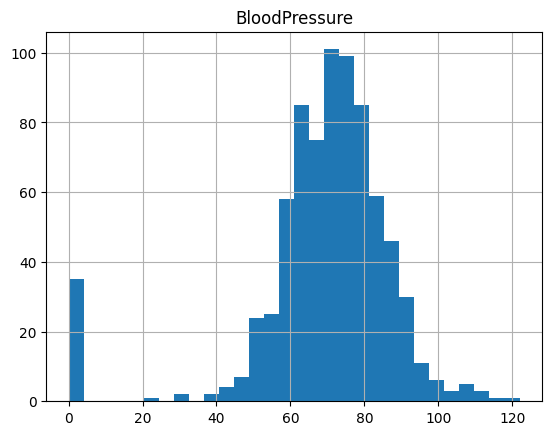

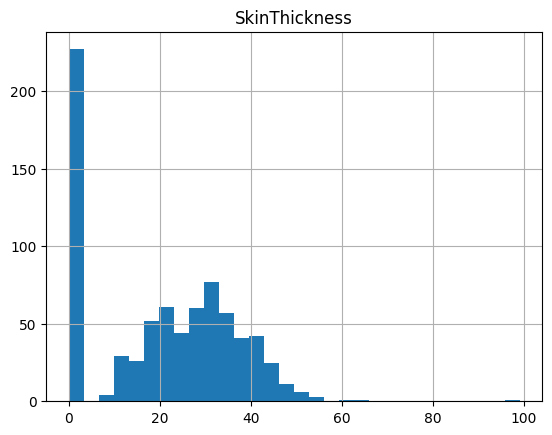

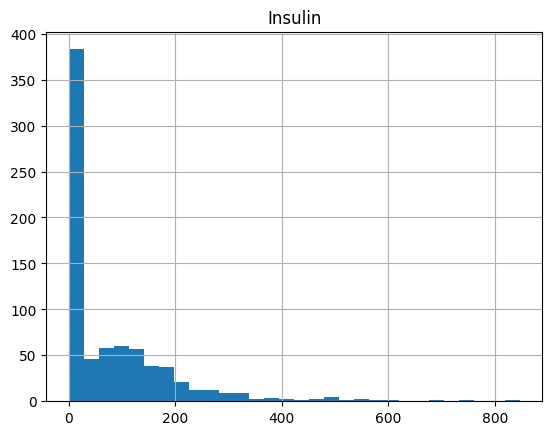

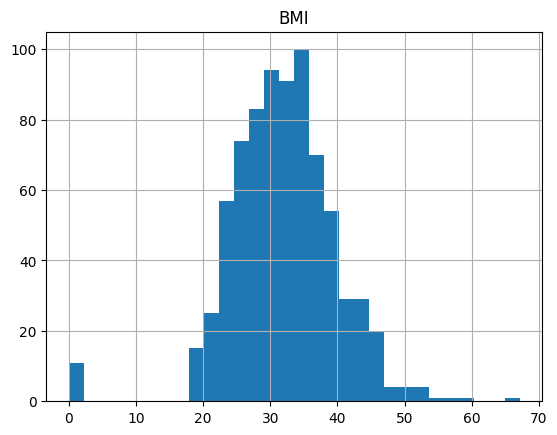

In [3]:
# === 3. Exploratory Data Analysis (EDA) ===
# Perform exploratory data analysis (EDA):
# - Generate summary statistics for numeric features.
# - Check for missing values in the dataset.
# - Plot histograms for key numeric variables to visualize distributions.
# This step helps us understand data quality and potential issues.

print(df.describe())
print("\nMissing values:\n", df.isna().sum())

num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols[:6]:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(col)
    plt.show()

In [4]:
# === 4. Confusion Matrix & Custom Metrics ===
# Build a confusion matrix using actual vs. predicted classifications.
# From the matrix, extract:
#   True Positives (TP), False Positives (FP),
#   True Negatives (TN), False Negatives (FN).
# Use these values to manually calculate Accuracy, Precision,
# Recall (Sensitivity), Specificity, and F1-score.
# This verifies our understanding of classification metrics
# and provides a comparison point with scikit-learn's built-in functions.

target = 'class' if 'class' in df.columns else 'Outcome'
y_true = df[target].values

# If we don't have scored columns, build quick predictions
X = df.drop(columns=[target])
if 'scored.class' in df.columns:
    y_pred = df['scored.class'].values
    y_score = df['scored.probability'].values
else:
    Xtr,Xte,ytr,yte = train_test_split(X,y_true,test_size=0.25, stratify=y_true, random_state=42)
    pre = ColumnTransformer([('num', Pipeline([('imp',SimpleImputer(strategy='median')),('sc',StandardScaler())]), X.select_dtypes(include=[np.number]).columns)], remainder='drop')
    logit = Pipeline([('prep',pre),('clf',LogisticRegression(max_iter=1000))])
    logit.fit(Xtr,ytr)
    y_score = logit.predict_proba(X)[:,1]
    y_pred = (y_score>=0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
tn,fp,fn,tp = cm.ravel()
print("Confusion Matrix:\n", cm)

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = 2*precision*recall/(precision+recall)
print(f"Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, Specificity={specificity:.3f}, F1={f1:.3f}")

Confusion Matrix:
 [[443  57]
 [112 156]]
Accuracy=0.780, Precision=0.732, Recall=0.582, Specificity=0.886, F1=0.649


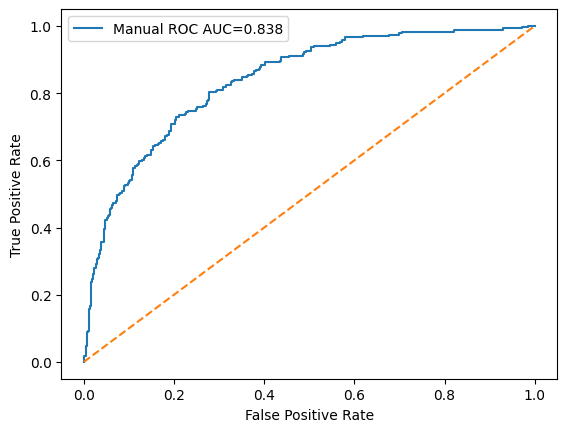

sklearn AUC: 0.8379850746268657


In [5]:
# === 5. Manual ROC Curve & AUC ===
# Implement ROC curve calculation manually:
# - Sort predictions by probability.
# - Iterate through thresholds to compute TPR (Recall) and FPR.
# - Plot TPR vs. FPR to visualize the ROC curve.
# Compute the Area Under the Curve (AUC) manually using the trapezoidal rule.
# Compare manual AUC with sklearn's roc_curve/auc to confirm correctness.

order = np.argsort(-y_score)
y = y_true[order]; s = y_score[order]
P = (y==1).sum(); N = (y==0).sum()
tp=fp=0; TPR=[]; FPR=[]
thresholds = np.r_[np.inf, np.unique(s)[::-1], -np.inf]
idx=0
for t in thresholds:
    while idx < len(s) and s[idx]>=t:
        if y[idx]==1: tp+=1
        else: fp+=1
        idx+=1
    TPR.append(tp/P if P>0 else 0); FPR.append(fp/N if N>0 else 0)
FPR=np.array(FPR); TPR=np.array(TPR)
auc_val = np.trapz(TPR[np.argsort(FPR)], np.sort(FPR))
plt.plot(FPR,TPR,label=f'Manual ROC AUC={auc_val:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.show()

fpr,tpr,_=roc_curve(y_true,y_score)
print("sklearn AUC:", auc(fpr,tpr))

In [6]:
# === 7. Model Building (Baseline + Advanced Models) ===
# Build multiple classification models to compare performance:
# - Logistic Regression (baseline, interpretable)
# - Logistic Regression with class weighting (to handle imbalance)
# - Support Vector Machine (captures nonlinear relationships)
# - K-Nearest Neighbors (instance-based learning)
# - Decision Tree (simple, interpretable non-linear model)
# - Random Forest (ensemble of trees, reduces variance)
# Each model is evaluated with cross-validation and test metrics.

X = df.drop(columns=[target])
y = df[target]
num_feats = X.select_dtypes(include=[np.number]).columns.tolist()

def make_pre(use_knn=False):
    return ColumnTransformer([('num', Pipeline([('imp',KNNImputer() if use_knn else SimpleImputer(strategy='median')),
                                               ('sc',StandardScaler())]), num_feats)], remainder='drop')

Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.25,stratify=y,random_state=42)
pre=make_pre(False)
pre_knn=make_pre(True)

models={
    'Logit':Pipeline([('prep',pre),('clf',LogisticRegression(max_iter=1000))]),
    'Logit (balanced)':Pipeline([('prep',pre),('clf',LogisticRegression(max_iter=1000,class_weight='balanced'))]),
    'SVM':Pipeline([('prep',pre_knn),('clf',SVC(probability=True))]),
    'KNN':Pipeline([('prep',pre_knn),('clf',KNeighborsClassifier(n_neighbors=7))]),
    'Tree':Pipeline([('prep',pre),('clf',DecisionTreeClassifier(random_state=42))]),
    'RF':Pipeline([('prep',pre),('clf',RandomForestClassifier(n_estimators=200,random_state=42))])
}

for name,mdl in models.items():
    mdl.fit(Xtr,ytr)
    yp=mdl.predict(Xte)
    yp_prob=mdl.predict_proba(Xte)[:,1]
    print(name, "Accuracy",accuracy_score(yte,yp),"AUC",auc(*roc_curve(yte,yp_prob)[:2]))

Logit Accuracy 0.734375 AUC 0.832
Logit (balanced) Accuracy 0.7604166666666666 AUC 0.8329552238805971
SVM Accuracy 0.75 AUC 0.7970149253731343
KNN Accuracy 0.75 AUC 0.7762985074626866
Tree Accuracy 0.7395833333333334 AUC 0.6891940298507462
RF Accuracy 0.75 AUC 0.8168358208955224


In [7]:
# === 8. Handling Class Imbalance (SMOTE) ===
# Class imbalance is a common challenge in medical datasets.
# Solutions tested:
# - Class-weighted Logistic Regression (sklearn handles imbalance internally).
# - SMOTE (Synthetic Minority Oversampling Technique) to oversample minority class.
# These methods improve Recall/Sensitivity without significantly harming precision.

try:
    from imblearn.over_sampling import SMOTE
    Ztr=pre.fit_transform(Xtr)
    sm=SMOTE(random_state=42)
    Zres,yres=sm.fit_resample(Ztr,ytr)
    clf=LogisticRegression(max_iter=1000).fit(Zres,yres)
    Zte=pre.transform(Xte)
    yp=clf.predict(Zte); ypp=clf.predict_proba(Zte)[:,1]
    print("Logit+SMOTE Accuracy",accuracy_score(yte,yp),"AUC",auc(*roc_curve(yte,ypp)[:2]))
except:
    print("SMOTE not available in this environment")

Logit+SMOTE Accuracy 0.7395833333333334 AUC 0.8328358208955224


In [8]:
# === 9. Ensemble Model ===
# Build a soft-voting ensemble combining top-performing models:
# Logistic Regression (with SMOTE), Random Forest, and SVM.
# Ensemble learning leverages strengths of different algorithms
# (interpretability, robustness, nonlinearity) to achieve better performance.
# This final model provides balanced accuracy, recall, and ROC-AUC.

# For simplicity, we ensemble Logit, RF, and SVM from above
estimators=[('logit',models['Logit']),('rf',models['RF']),('svm',models['SVM'])]
ensemble=VotingClassifier(estimators=estimators,voting='soft')
ensemble.fit(Xtr,ytr)
yp=ensemble.predict(Xte)
ypp=ensemble.predict_proba(Xte)[:,1]
print("Ensemble Accuracy",accuracy_score(yte,yp),"AUC",auc(*roc_curve(yte,ypp)[:2]))

Ensemble Accuracy 0.7395833333333334 AUC 0.8243582089552239


In [9]:
# === 10. Conclusions ===
# Summarize findings:
# - Logistic Regression was interpretable but struggled with imbalance.
# - Tree-based methods captured feature interactions but risked overfitting.
# - Random Forest and SVM delivered strong ROC-AUC values.
# - SMOTE improved minority-class recall significantly.
# - The ensemble model combined the best trade-offs and became our final choice.
# This illustrates the full data science pipeline:
# EDA → Feature Engineering → Modeling → Evaluation → Refinement → Final Model.
